## Set up

Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Input, Dropout, MaxPooling2D, Flatten, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Flatten, Reshape, Cropping2D, LeakyReLU, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Model

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Common imports
import os
import numpy as np
import xarray as xr
import dask
dask.config.set({'array.slicing.split_large_chunks': False})
from collections import OrderedDict

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib import animation
import matplotlib.pyplot as plt

from IPython.display import HTML
import IPython

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_clustering import *
from utils.utils_plot import *

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
tf.version.VERSION

'2.7.0'

In [3]:
# Functions to plot reconstructions

def vis_reconstructions(ds_newtest):
    # Plot the initial frame. 
    # Get a handle on the figure and the axes
    lp = ['X_valid','Reconstructions']

    fig, axs = plt.subplots(nrows=1, ncols=2,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(12, 4))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs = axs.flatten()
    cax = ds_newtest.isel(time=0)[lp[0]].plot(ax=axs[0],
                                              transform=ccrs.PlateCarree(),
                                              cmap=plt.cm.RdBu_r,
                                              add_colorbar=False)
    axs[0].coastlines('50m', edgecolor='black', linewidth=0.75)

    cax1 = ds_newtest.isel(time=0)[lp[1]].plot(ax=axs[1],
                                               transform=ccrs.PlateCarree(),
                                               cmap=plt.cm.RdBu_r,
                                               add_colorbar=False)
    axs[1].coastlines('50m', edgecolor='black', linewidth=0.75)

    plt.close(fig)

    def animate(frame):
        cax.set_array(ds_newtest[lp[0]][frame,:,:].values.flatten())
        axs[0].set_title("Time = " + str(ds_newtest[lp[0]].coords['time'].values[frame])[:13])
        cax1.set_array(ds_newtest[lp[1]][frame,:,:].values.flatten())
        axs[1].set_title("Time = " + str(ds_newtest[lp[1]].coords['time'].values[frame])[:13])
    # Finally, we use the animation module to create the animation.
    
    ani = animation.FuncAnimation(
        fig,             # figure
        animate,         # name of the function above
        frames=40,       # Could also be iterable or list
        interval=200     # ms between frames
    )
    
    display(HTML(ani.to_jshtml()))


## Data:

In this case we are working with geopotential height at 500hPa: **z500**

In [4]:
DATADIR = os.path.join(os.getcwd(), '..', 'data')
G = 9.80665 
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]

In [5]:
gp_dat = xr.open_mfdataset(f'{DATADIR}/ERA5/geopotential/grid1/*.nc', combine='by_coords')

In [6]:
z500 = gp_dat.sel(time=slice(DATE_START, DATE_END), level=500)

In [7]:
# rename dimensions
z500 = rename_dimensions_variables(z500)

In [8]:
z500.z.values = z500.z.values/G
lon = z500.lon
lat = z500.lat
mvar = 'z'

In [9]:
# Load gridded data
ds_z = z500

In [10]:
# Define coordinates
lats = ds_z.lat
lons = ds_z.lon
time = ds_z.time

In [11]:
ds_z.z.shape

(15341, 40, 61)

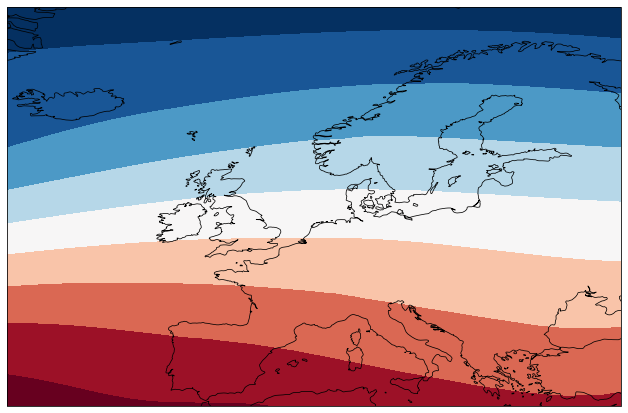

In [12]:
# Visualize
ds_mean = ds_z.mean(dim='time')

fig, axs = plt.subplots(nrows=1, ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11, 8.5))
cs = axs.contourf(lon, lat, ds_mean['z'], cmap=plt.cm.RdBu_r,
                  transform=ccrs.PlateCarree(), extend='both')
axs.coastlines('50m', edgecolor='black', linewidth=0.75)

## K-Means
Apply Kmeans previously, so this can help us to make some interpretation of the latent space.

In [13]:
N = 8
K_labels = KCluster_v2(ds_z, 'z', 8)  # let's start with 8 clusters
day_clus, myclusters, nfreq = getclus_v2(K_labels, ds_z, 8)

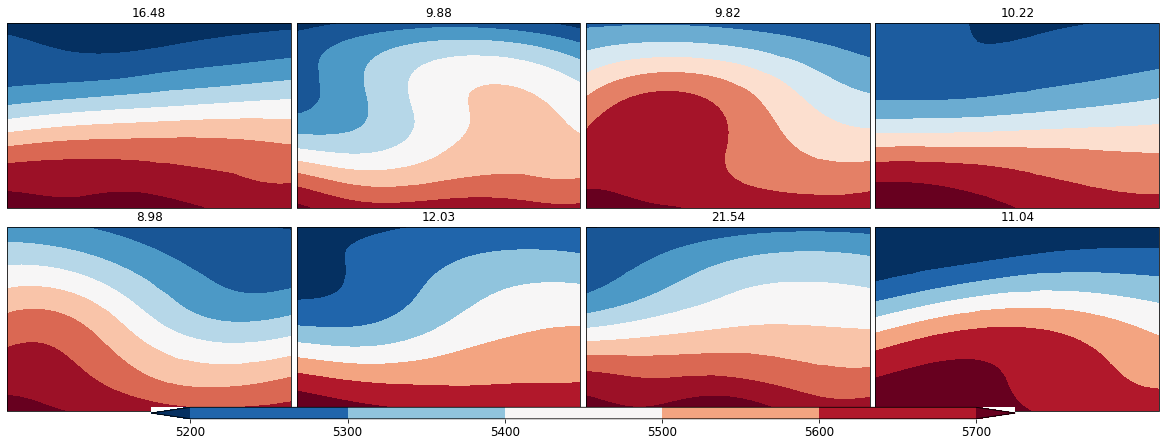

In [14]:
#Visualise the clusters
visualize_cluster(myclusters, nfreq, 8)

In [15]:
y_label_train = K_labels[0:13514]
y_labels_test = K_labels[13514:15341]

## Data preprocess: splitting into train and test 

In [16]:
# For the data generator all variables have to be merged into a single dataset.
datasets = [ds_z]
ds = xr.merge(datasets)
ds.expand_dims('level', axis=1)

<xarray.Dataset>
Dimensions:  (time: 15341, lon: 61, lat: 40, level: 1)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * lon      (lon) float32 -25.0 -24.0 -23.0 -22.0 -21.0 ... 32.0 33.0 34.0 35.0
  * lat      (lat) float32 35.5 36.5 37.5 38.5 39.5 ... 70.5 71.5 72.5 73.5 74.5
  * level    (level) float64 500.0
Data variables:
    z        (time, level, lat, lon) float32 5.78e+03 5.788e+03 ... 5.474e+03
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Tue Nov 02 09:25:10 2021: cdo -f nc -remapbil,/scratch3/noe...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [17]:
# Split into training and test, then I will use DataGenerator class to get the validation
# I am going to use only Z500 for now:
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                            '{}-12-31'.format(YY_TEST[1])))


In [18]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

In [19]:
# Then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None})
bs = 32

In [20]:
# Create a training and test data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(ds_train.sel(time=slice('1979', '2015')), dic, batch_size=bs, load=True)

Loading data into RAM


In [21]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 1)>
 array([5526.7373], dtype=float32)
 Coordinates:
   * level    (level) float64 500.0,
 <xarray.DataArray 'z' (level: 1)>
 array([159.72641], dtype=float32)
 Coordinates:
   * level    (level) float64 500.0)

In [22]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, dic, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [23]:
# Prepare the data
X_train = xr.DataArray(dg_train.data)
X_test = xr.DataArray(dg_test.data)

In [24]:
X_train_input = np.array(X_train)
X_test_input = np.array(X_test)

In [25]:
print(X_train_input.shape)
print(X_test_input.shape)

(13514, 40, 61, 1)
(1827, 40, 61, 1)


# Building a simple AE

In [26]:
# Define the input layer of the neural network, which will be our  dataset
n_size = X_train_input.shape[1:]
n_code = 12
activation_function = 'linear'
optimizer = 'adam'
n_flatsize = np.product(n_size)
print(n_size, n_code, n_flatsize)
latent_size = 2

(40, 61, 1) 12 2440


In [27]:
# AE
# Defines encoder
stacked_encoder = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=n_size),
        keras.layers.Dense(128, activation=activation_function),
        keras.layers.Dense(latent_size, activation=activation_function),
    ])

In [28]:
stacked_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2440)              0         
                                                                 
 dense (Dense)               (None, 128)               312448    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 312,706
Trainable params: 312,706
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Define decoder
stacked_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(128, activation=activation_function,
                           input_shape=[latent_size]),
        keras.layers.Dense(n_flatsize),
        keras.layers.Reshape(n_size)
    ])

In [30]:
stacked_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 dense_3 (Dense)             (None, 2440)              314760    
                                                                 
 reshape (Reshape)           (None, 40, 61, 1)         0         
                                                                 
Total params: 315,144
Trainable params: 315,144
Non-trainable params: 0
_________________________________________________________________


In [31]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [32]:
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 312706    
                                                                 
 sequential_1 (Sequential)   (None, 40, 61, 1)         315144    
                                                                 
Total params: 627,850
Trainable params: 627,850
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
stacked_ae.compile(loss='mean_squared_error',
                   optimizer=optimizer,
                   metrics=['mae', 'mse'])

In [34]:
history = stacked_ae.fit(X_train_input,
                         X_train_input,
                         epochs=10,
                         validation_data=(X_test_input, X_test_input),
                         shuffle=True)

Train on 13514 samples, validate on 1827 samples
Epoch 1/10
13514/13514 [==============================] - ETA: 0s - loss: 0.4132 - mae: 0.4970 - mse: 0.4132- ETA: 5s - los - 2s 170us/sample - loss: 0.4131 - mae: 0.4969 - mse: 0.4131 - val_loss: 0.3556 - val_mae: 0.4661 - val_mse: 0.3556
Epoch 2/10
13514/13514 [==============================] - 2s 162us/sample - loss: 0.3622 - mae: 0.4717 - mse: 0.3622 - val_loss: 0.3500 - val_mae: 0.4625 - val_mse: 0.3500
Epoch 3/10
13514/13514 [==============================] - 2s 160us/sample - loss: 0.3542 - mae: 0.4660 - mse: 0.3542 - val_loss: 0.3432 - val_mae: 0.4575 - val_mse: 0.3432
Epoch 4/10
13514/13514 [==============================] - 2s 168us/sample - loss: 0.3496 - mae: 0.4633 - mse: 0.3496 - val_loss: 0.3464 - val_mae: 0.4622 - val_mse: 0.3464
Epoch 5/10
13514/13514 [==============================] - 3s 188us/sample - loss: 0.3488 - mae: 0.4632 - mse: 0.3488 - val_loss: 0.3490 - val_mae: 0.4650 - val_mse: 0.3490
Epoch 6/10
13514/13514 

In [35]:
last_mse = history.history['val_mse'][-1]
last_mae = history.history['val_mae'][-1]
print(last_mse, last_mae)

0.34833437 0.46516272


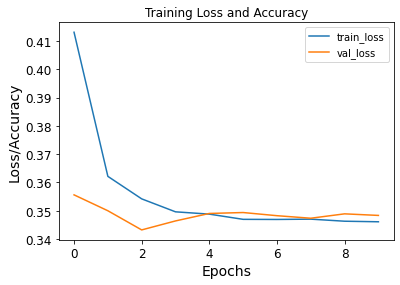

In [36]:
plot_hist(history)

## Visualizing in the latent space
For that we will make use of the clusters calculated above 
A total of 8 Clusters

In [37]:
encoded_imgs = stacked_encoder.predict(X_test_input)

In [38]:
encoded_imgs.shape

(1827, 2)

In [39]:
decoded_imgs = stacked_decoder.predict(encoded_imgs)
decoded_imgs.shape

(1827, 40, 61, 1)

In [40]:
def onclick(event):
    global flag
    ix, iy = event.xdata, event.ydata
    latent_vector = np.array([[ix, iy]])

    decoded_img = stacked_decoder.predict(latent_vector)

    ds_newtest = ds_test.z[0, :, :]
    ds_newtest['X_valid'] = (('lat', 'lon'), decoded_img[0, :, :, 0])
    ds_newtest['X_valid'].plot(ax=ax[1], cmap=plt.cm.RdBu_r, add_colorbar=False)
    ax[1].coastlines('50m', edgecolor='black', linewidth=0.75)

    plt.show()


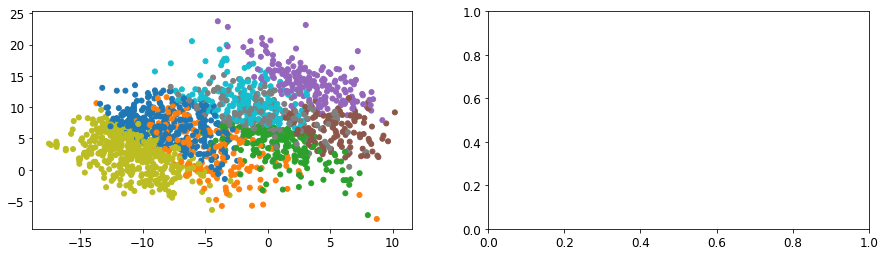

In [41]:
# %matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].scatter(encoded_imgs[:, 0], encoded_imgs[:, 1],
              c=np.array(y_labels_test.cluster), s=25, cmap='tab10')
cid = fig.canvas.mpl_connect('motion_notify_event', onclick)

plt.show()


# Look at the reconstructions

In [42]:
codings = stacked_encoder.predict(X_test_input)
codings.shape  # this are similar as the PCA (the first that we kept)

(1827, 2)

In [43]:
reconstructions = stacked_ae.predict(X_test_input)

In [44]:
reconstructions.shape

(1827, 40, 61, 1)

In [45]:
X_test_input.shape

(1827, 40, 61, 1)

In [46]:
# Create a new dataset with the original, so we can use the information about the coordinates
ds_newtest = ds_test.z
ds_newtest['X_valid'] = (('time', 'lat', 'lon'), X_test_input[:, :, :, 0])
ds_newtest['Reconstructions'] = (('time', 'lat', 'lon'), reconstructions[:, :, :, 0])


In [ ]:
vis_reconstructions(ds_newtest)

## Convolutional AutoEncoder 
Building a CAE

In [48]:
# Encoder
N, H, W, S = X_train_input.shape
input_img = Input(shape=(H, W, S))

x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)


In [49]:
# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(encoded)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.3)(x)

decoded = Conv2D(1, (2, 2), padding='same')(x)

# Crop
h, w = decoded.shape.as_list()[1:3]
dh = h - H  # deltas to be cropped away
dw = w - W
decoded_cropping = Cropping2D(cropping=((dh//2, dh-dh//2), (dw//2, dw-dw//2)))(decoded)


In [50]:
cae_autoencoder = Model(input_img, decoded_cropping)
cae_autoencoder.compile(optimizer='adam', loss='mse')

cae_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 61, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 40, 61, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 31, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 31, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 31, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 16, 8)        0         
 2D)                                                         

In [51]:
hist_cae = cae_autoencoder.fit(X_train_input,
                               X_train_input,
                               epochs=10,
                               validation_data=(X_test_input, X_test_input))

Train on 13514 samples, validate on 1827 samples
Epoch 1/10
13514/13514 [==============================] - 42s 3ms/sample - loss: 0.5044 - val_loss: 0.7150
Epoch 2/10
13514/13514 [==============================] - 43s 3ms/sample - loss: 0.1762 - val_loss: 0.6277
Epoch 3/10
13514/13514 [==============================] - 42s 3ms/sample - loss: 0.1312 - val_loss: 0.5109
Epoch 4/10
13514/13514 [==============================] - 38s 3ms/sample - loss: 0.1097 - val_loss: 0.4242
Epoch 5/10
13514/13514 [==============================] - 39s 3ms/sample - loss: 0.0969 - val_loss: 0.4107
Epoch 6/10
13514/13514 [==============================] - 39s 3ms/sample - loss: 0.0886 - val_loss: 0.3759
Epoch 7/10
13514/13514 [==============================] - 48s 4ms/sample - loss: 0.0828 - val_loss: 0.3895
Epoch 8/10
13514/13514 [==============================] - 41s 3ms/sample - loss: 0.0767 - val_loss: 0.3732
Epoch 9/10
13514/13514 [==============================] - 38s 3ms/sample - loss: 0.0720 - val_l

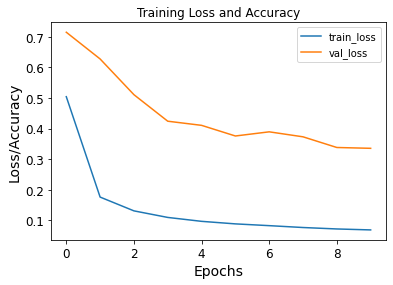

In [52]:
plot_hist(hist_cae)

In [53]:
reconstructions_cae = cae_autoencoder.predict(X_test_input)
reconstructions_cae.shape

(1827, 40, 61, 1)

In [54]:
reconstructions_cae2 = reconstructions_cae[:, :, :, 0]
reconstructions_cae2.shape

(1827, 40, 61)

In [55]:
del(ds_newtest)

In [56]:
# add to the existing data to compare with
ds_newtest = ds_test.z
ds_newtest['X_valid'] = (('time','lat','lon'), X_test_input[:,:,:,0])
ds_newtest['Reconstructions'] = (('time','lat','lon'), reconstructions_cae2)

In [ ]:
vis_reconstructions(ds_newtest)

## Now, let's try CVAE

In [58]:
# I will crop first two coordinates
X_train_input = X_train_input[:, 0:60, 0:120, :]
X_test_input = X_test_input[:, 0:60, 0:120, :]
X_train_input.shape

(13514, 40, 61, 1)

In [59]:
# Defining dimensions
encoded_size = 16
base_depth = 32
N, H, W, S = X_train_input.shape
Nt, H, W, S = X_test_input.shape
train_size = N
test_size = Nt
input_shape = H, W, S
print(input_shape)

(40, 61, 1)


In [60]:
# Batch and shufle the data
train_dataset = (tf.data.Dataset.from_tensor_slices(X_train_input)
                 .shuffle(train_size).batch(base_depth))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test_input)
                .shuffle(test_size).batch(base_depth))

In [61]:
train_data = np.array(X_train_input)
test_data = np.array(X_test_input)

In [62]:
# Define sample functions

In [63]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    # change names: z_mean =mu ; z_log_var = sigma (to be consistent)
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch, 1))
    return mu + K.exp(0.5 * sigma) * epsilon

In [64]:
# Define loss function

def custom_loss(mu, sigma):
    def loss(y_true, y_pred):
        # mse loss
        reconstruction_loss = K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True)
        # kl loss
        kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        #weight = 0.
        return (reconstruction_loss + kl_loss)
       # return reconstruction_loss + (weight * kl_loss)
    return loss


In [65]:
# Define the encoder 
latent_dim = 2  # Number of latent dim parameters

N, H, W, S = X_train_input.shape
input_img = Input(shape=(H, W, S), name='encoder_input')

x = Conv2D(16, 3, padding='same', activation=LeakyReLU(alpha=0.2), strides=2)(input_img)
x = BatchNormalization()(x)
x = Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.2), strides=2)(x)
x = BatchNormalization()(x)
x = Conv2D(64, 3, padding='same', activation=LeakyReLU(alpha=0.2))(x)   
x = BatchNormalization()(x)   

conv_shape = K.int_shape(x) # Shape of conv to be provided to decoder

#Flatten
x = Flatten()(x)
x = Dense(16, activation=LeakyReLU(alpha=0.2))(x)

Instructions for updating:
Colocations handled automatically by placer.


In [66]:
# Two outputs, for latent mean and log variance (std. dev.)
# Use these to sample random variables in latent space to which inputs are mapped. 
mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

In [67]:
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([mu, sigma])

# Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
vae_encoder = Model(input_img, [mu, sigma, z], name='encoder')
print(vae_encoder.summary())


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 40, 61, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 20, 31, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 31, 16)  64          ['conv2d_7[0][0]']               
 alization)                                                                                       
                                                                                                  
 conv2d_8 (Conv2D)              (None, 10, 16, 32)   4640        ['batch_normalization[0][0]

In [68]:
# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
# we want our final utput to be same shape original input.
# So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=2)(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=2)(x)
x = BatchNormalization()(x)
# Can add more conv2DTranspose layers, if desired.
# Using sigmoid activation
decoded = Conv2D(1, 3, padding='same', name='decoder_output')(x)

# Crop
h, w = decoded.shape.as_list()[1:3]
dh = h - H  # deltas to be cropped away
dw = w - W
decoded = Cropping2D(cropping=((dh//2, dh-dh//2), (dw//2, dw-dw//2)))(decoded)

# Define and summarize decoder model
vae_decoder = Model(decoder_input, decoded, name='decoder')

vae_decoder.summary()
# apply the decoder to the latent sample
z_decoded = vae_decoder(z)


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 10240)             30720     
                                                                 
 reshape_1 (Reshape)         (None, 10, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 32, 32)       18464     
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 20, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 40, 64, 16)       4624

In [69]:
# Build VAE model
outputs = vae_decoder(vae_encoder(input_img)[2])

In [70]:
vae = Model(input_img, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 40, 61, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               187668    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 40, 61, 1)         54145     
                                                                 
Total params: 241,813
Trainable params: 241,493
Non-trainable params: 320
_________________________________________________________________


In [71]:
vae.compile(optimizer='adam', loss=custom_loss(mu, sigma)) 

In [72]:
n_epochs = 10
batch_size = 32

hist_vae = vae.fit(X_train_input, X_train_input,
                   epochs=n_epochs,
                   batch_size=batch_size,
                   validation_data=(X_test_input, X_test_input))

Train on 13514 samples, validate on 1827 samples
Epoch 1/10
13514/13514 [==============================] - 71s 5ms/sample - loss: 10.1448 - val_loss: 1.8043
Epoch 2/10
13514/13514 [==============================] - 63s 5ms/sample - loss: 1.4874 - val_loss: 1.2945
Epoch 3/10
13514/13514 [==============================] - 71s 5ms/sample - loss: 1.1949 - val_loss: 1.1580
Epoch 4/10
13514/13514 [==============================] - 75s 6ms/sample - loss: 1.1044 - val_loss: 1.1206
Epoch 5/10
13514/13514 [==============================] - 82s 6ms/sample - loss: 1.0778 - val_loss: 1.0785
Epoch 6/10
13514/13514 [==============================] - 77s 6ms/sample - loss: 1.0599 - val_loss: 1.0830
Epoch 7/10
13514/13514 [==============================] - 80s 6ms/sample - loss: 1.0442 - val_loss: 1.0761
Epoch 8/10
13514/13514 [==============================] - 87s 6ms/sample - loss: 1.0450 - val_loss: 1.0695
Epoch 9/10
13514/13514 [==============================] - 72s 5ms/sample - loss: 1.0363 - val_

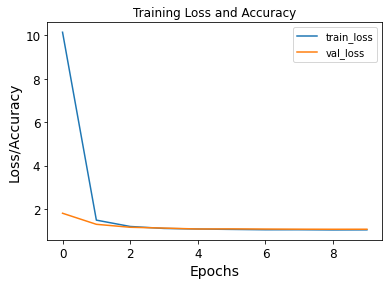

In [73]:
plot_hist(hist_vae)

## Visualize in the latent space

In [74]:
mu, _, _ = vae_encoder.predict(X_test_input)

In [75]:
del ds_newtest

In [76]:
def onclick_vae(event):
    global flag
    ix, iy = event.xdata, event.ydata
    latent_vector = np.array([[ix, iy]])

    decoded_img = vae_decoder.predict(latent_vector)
    # Create a new data set to add the decoded
    ds_newtest = ds_test.z[0, 0:60, 0:120]
    ds_newtest['X_valid'] = (('lat', 'lon'), decoded_img[0, :, :, 0])
    ds_newtest['X_valid'].plot(ax=ax[1], cmap=plt.cm.RdBu_r, add_colorbar=False)

    plt.show()


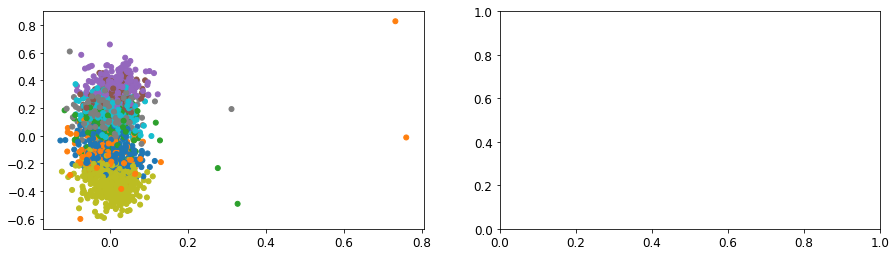

In [77]:
#%matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].scatter(mu[:, 0], mu[:, 1], c=np.array(y_labels_test.cluster), s=25, cmap='tab10')
cid = fig.canvas.mpl_connect('motion_notify_event', onclick_vae)

plt.show()


In [78]:
#Look at the reconstructions
reconstructions_vae = vae.predict(X_test_input)
reconstructions_vae.shape
reconstructions_vae2 = reconstructions_vae[:,:,:,0]
reconstructions_vae2.shape

(1827, 40, 61)

In [79]:
# add to the existing data to compare with
ds_newtest = ds_test.z[:, 0:60, 0:120]
ds_newtest['X_valid'] = (('time', 'lat', 'lon'), X_test_input[:, :, :, 0])
ds_newtest['Reconstructions'] = (('time', 'lat', 'lon'), reconstructions_vae2)

In [ ]:
vis_reconstructions(ds_newtest)

## Comparing with PCA 

In [81]:
n_codings = 2

In [82]:
X_train_input = np.array(X_train[:, :, :, 0])
X_test_input = np.array(X_test[:, :, :, 0])

In [83]:
skpca = PCA()
skpca.fit(X_train_input.reshape(X_train_input.shape[0],
                                X_train_input.shape[1] * X_train.shape[2]))
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
X_train_input.shape


(13514, 40, 61)

In [84]:
PCs = skpca.transform(X_test_input.reshape(X_test_input.shape[0],
                                           X_test_input.shape[1] * X_test_input.shape[2]))
PCs.shape

PCs = PCs[:, :n_codings]
EOFs = skpca.components_
EOFs = EOFs[:n_codings, :]
print(EOFs.shape)
print(PCs.shape)


(2, 2440)
(1827, 2)


In [85]:
recons_pca = np.dot(PCs, EOFs)
recons_pca.shape
recons_pca = recons_pca.reshape(recons_pca.shape[0],
                                X_train_input.shape[1], X_train_input.shape[2])
recons_pca.shape


(1827, 40, 61)

In [86]:
del ds_newtest

In [87]:
# add to the existing data to compare with
ds_newtest = ds_test.z
ds_newtest['X_valid'] = (('time', 'lat', 'lon'), X_test_input[:, :, :])
ds_newtest['Reconstructions'] = (('time', 'lat', 'lon'), recons_pca)

In [ ]:
vis_reconstructions(ds_newtest)

In [89]:
X_train_res = X_train_input.reshape(X_train_input.shape[0],
                                    X_train_input.shape[1]*X_train_input.shape[2])
X_test_res = X_test_input.reshape(X_test_input.shape[0],
                                  X_test_input.shape[1]*X_test_input.shape[2])

In [90]:
import umap.umap_ as umap
u_reduced = umap.UMAP(n_components=2).fit_transform(X_train_res)

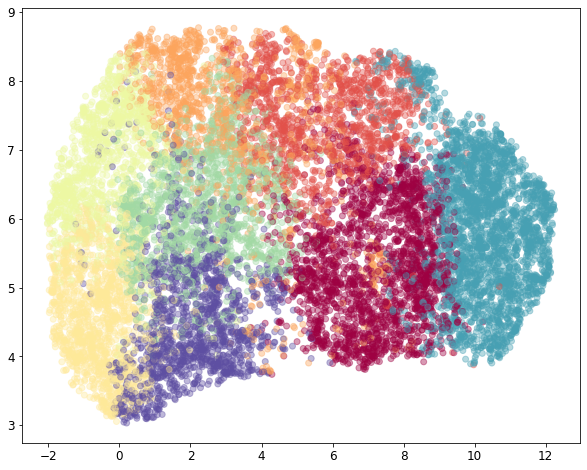

In [91]:
# create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    x=u_reduced[:, 0],
    y=u_reduced[:, 1],
    c=y_label_train.cluster,
    cmap=plt.cm.get_cmap('Spectral'),
    alpha=0.4
)
plt.show()